# Probabilistic Methods (Discrete)


When you have a variable that is not too noisy, you can have a baseline probability, then as new datapoints come in you can identify and compare the actual rate with the expected rate (probability).

In [2]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

### Wrangle Data

#### Acquire:

In [3]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [4]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


#### Parse Datetime:

In [6]:
# begin cleaning up the timestamp by removing the brackets and extraneous tail

df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [7]:
df.head(2)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


In [8]:
# replace the first colon in the timestamp before year 
# to accomodate for pandas datetime
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
# reset index to time
df = df.set_index('timestamp')

In [9]:
df.head(2)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


#### Cleanup Text:

In [10]:
# clean up strings in columns with extra quotes
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


#### Add Variable - Converting bytes to mb:

In [11]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [12]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [13]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Detecting Anomalies in Discrete Variables

### Finding anomalies in already existing data:

We can easily see some anomalies around IP addresses.

In [22]:
# get the counts of ips in the dataset
ip_df = df.ip.value_counts(dropna=False).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_count'})

In [24]:
# get the probability of that ip in the dataset
ip_df2 = (df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_proba'})
# merge/join these together
ip_df = ip_df.merge(ip_df2)

In [25]:
ip_df.head()

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


In [26]:
ip_df.shape

(22, 3)

In [29]:
# alter the ip df to only see those where rate < 1% 
ip_df[ip_df.ip_proba < 0.01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,52.87.230.102,2,0.000143
7,35.175.171.137,2,0.000143
8,70.121.214.34,2,0.000143
9,95.31.18.119,1,0.000072
10,3.92.201.136,1,0.000072
11,34.229.70.250,1,0.000072
12,45.23.250.16,1,0.000072
13,52.91.30.150,1,0.000072


22
               ip  ip_count  ip_proba
12   45.23.250.16         1  0.000072
13   52.91.30.150         1  0.000072
14  97.105.15.120         1  0.000072
15  52.90.165.200         1  0.000072
16   3.88.129.158         1  0.000072
17  54.172.14.223         1  0.000072
18   35.174.209.2         1  0.000072
19  34.207.64.242         1  0.000072
20   95.31.16.121         1  0.000072
21  54.145.52.184         1  0.000072


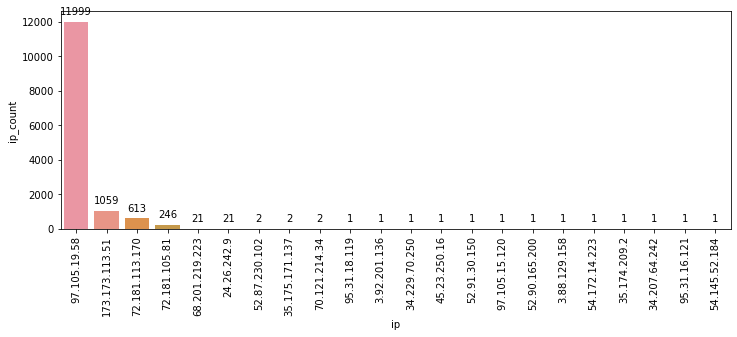

In [32]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
plt.xticks(rotation='vertical')
plt.show()

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.
#### Establish Baseline:

In [33]:
# create a training set
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [36]:
train.size /df.size

0.9997138360280441

In [37]:
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

#### Compute probabilities based on train sample:

In [39]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().rename(columns={'index': 'ip', 'ip': 'ip_proba'})

#### Merge probabilities with all data (train + new data):

- Where the IP address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [42]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')

In [45]:
# value counts?
df[df['ip_proba'] == 0]

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,,
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,0,python-requests/2.21.0,1.099591,0.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,0,python-requests/2.21.0,0.000958,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,2560,0,python-requests/2.21.0,0.002441,0.0


### Conditional Probabilities: Probabilities using 2 discrete variables

#### Probability of Status given IP Address:
If we are looking for an unexpected status (like authentication failure) from a known/common IP address. 

In [ ]:
# prob(A|B) = prob(A & B) / prob(B)

In [51]:
ip_probs = train.groupby('ip').size().div(len(train))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).size().div(len(train)).\
                              div(ip_probs,
                                 axis=0,
                                 level='ip').\
                              reset_index().\
                              rename(columns={0: 'proba_status_given_ip'})
                              )

In [52]:
status_given_ip

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [53]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                              count().reset_index().\
                              rename(columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)

In [54]:
ip_status

,ip,status,proba_status_given_ip,ip_status_count
0,173.173.113.51,200,1.000000,1059
1,24.26.242.9,200,1.000000,21
2,3.88.129.158,200,1.000000,1
3,3.92.201.136,200,1.000000,1
4,34.207.64.242,200,1.000000,1
5,34.229.70.250,200,1.000000,1
6,35.174.209.2,200,1.000000,1
7,35.175.171.137,200,1.000000,2
8,45.23.250.16,200,1.000000,1
9,52.87.230.102,200,1.000000,2


#### Add these probabilities to original events to detect anomalous events:

In [56]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [57]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.998833,11984.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.998833,11984.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.998833,11984.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.998833,11984.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.998833,11984.0


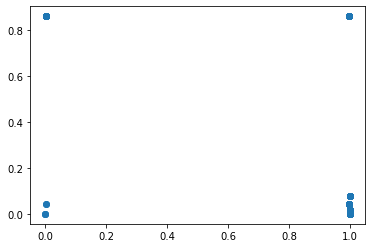

In [59]:
# scatter plot
plt.scatter(df.proba_status_given_ip, df.ip_proba)
plt.show()

In [62]:
df[(df['proba_status_given_ip'] > 0.9) & (df['ip_proba'] < 0.2)]

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:39:14,3.92.201.136,GET / HTTP/1.1,200,42,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040,0.000072,1.0,1.0
2019-04-16 19:39:15,52.90.165.200,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.0,1.0
2019-04-16 19:40:32,3.88.129.158,GET /api/v1/items HTTP/1.1,200,3561,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396,0.000072,1.0,1.0
2019-04-16 19:40:33,34.207.64.242,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.0,1.0
2019-04-16 19:40:36,54.172.14.223,GET /api/v1/ HTTP/1.1,200,162,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000154,0.000072,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2019-04-17 06:15:07,24.26.242.9,GET /api/v1/sales HTTP/1.1,200,493905,0,python-requests/2.21.0,0.471025,0.001503,1.0,21.0
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.001503,1.0,21.0
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/stores HTTP/1.1,200,1328,0,python-requests/2.21.0,0.001266,0.001503,1.0,21.0


# Exercise

**file name:** discrete_anomaly_detection.py or discrete_anomaly_detection.ipynb

Save this work in your `anomaly-detection-exercises` repo. Then add, commit, and push your changes.

### Discrete Data + Probability

- Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.